##### Overview #####

You've joined a healthcare analytics team, and your first project is to build a model that predicts which patients are likely to be readmitted within 30 days after discharge. Your initial decision tree model shows promising results but needs tuning to be reliable enough for clinical use.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# Load patient data 
patient_data = pd.DataFrame({
    'age': np.random.normal(65, 15, 1000),
    'length_of_stay': np.random.normal(5, 2, 1000),
    'num_medications': np.random.normal(7, 3, 1000),
    'num_procedures': np.random.normal(2, 1, 1000),
    'num_lab_procedures': np.random.normal(10, 3, 1000),
    'num_diagnoses': np.random.normal(7, 2, 1000)
})

In [2]:
# Create target variable (readmitted within 30 days)
# Assume readmission is more likely with longer stays and more medications
readmission_prob = (0.3 * (patient_data['length_of_stay'] > 5) + 
                   0.3 * (patient_data['num_medications'] > 8) +
                   0.4 * np.random.random(1000))
patient_data['readmitted'] = (readmission_prob > 0.5).astype(int)

In [3]:
# Split the data
X = patient_data.drop('readmitted', axis=1)
y = patient_data['readmitted']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [4]:
# First, evaluate initial model with cross-validation
initial_model = DecisionTreeClassifier(random_state=42)
initial_scores = cross_val_score(
    initial_model, X_train, y_train, cv=5, scoring='roc_auc'
)
print("Initial model performance:")
print(f"ROC-AUC: {initial_scores.mean():.3f} (+/- {initial_scores.std() * 2:.3f})")

Initial model performance:
ROC-AUC: 0.757 (+/- 0.042)


In [5]:
# Implement systematic tuning 
def evaluate_model_complexity():
    """Evaluate how model performance changes with tree depth"""
    max_depths = range(1, 20)
    train_scores = []
    val_scores = []
    
    for depth in max_depths:
        model = DecisionTreeClassifier(max_depth=depth, random_state=42)
        model.fit(X_train, y_train)
        
        train_scores.append(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
        val_scores.append(np.mean(cross_val_score(
            model, X_train, y_train, cv=5, scoring='roc_auc'
        )))
    
    plt.figure(figsize=(10, 6))
    plt.plot(max_depths, train_scores, label='Training Score')
    plt.plot(max_depths, val_scores, label='Cross-validation Score')
    plt.xlabel('Maximum Tree Depth')
    plt.ylabel('ROC-AUC Score')
    plt.title('Model Complexity Analysis')
    plt.legend()
    plt.show()
    
    return max_depths, train_scores, val_scores

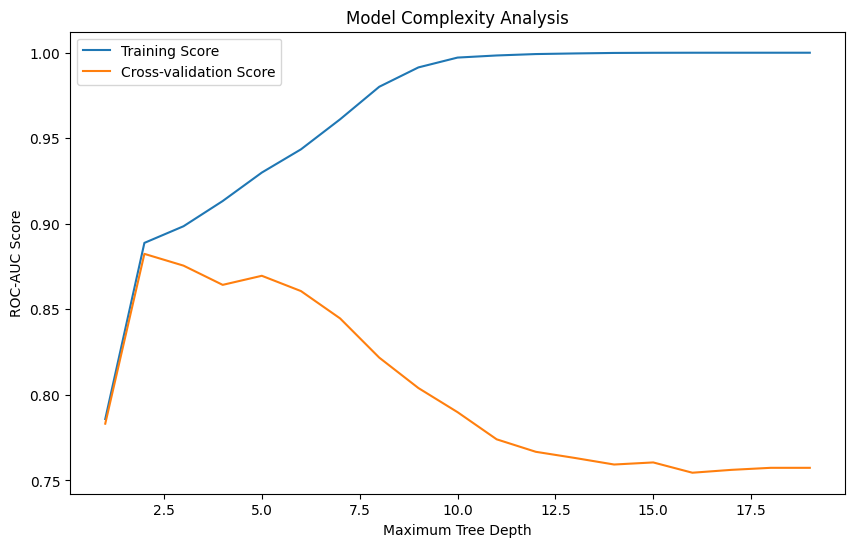

In [6]:
# Analyze model complexity
max_depths, train_scores, val_scores = evaluate_model_complexity()

In [8]:
# Based on the complexity analysis, let's do a focused grid search
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_leaf': [10, 20, 30, 40, 50],
    'min_samples_split': [20, 40, 60, 80, 100]
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': [3, 4, ...], 'min_samples_leaf': [10, 20, ...], 'min_samples_split': [20, 40, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [9]:
# Evaluate our tuned model
final_model = grid_search.best_estimator_
final_scores = cross_val_score(
    final_model, X_train, y_train, cv=5, scoring='roc_auc'
)

In [10]:
# Evaluate the true test score performance
final_test_score = roc_auc_score(y_test, final_model.predict(X_test))

print("\nTuned model cv performance:")
print(f"Best parameters: {grid_search.best_params_}")
print(f"ROC-AUC: {final_scores.mean():.3f} (+/- {final_scores.std() * 2:.3f})")
print(f"Final Model ROC-AUC Evaluation on Test Data: {final_test_score:.3f}")


Tuned model cv performance:
Best parameters: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 60}
ROC-AUC: 0.888 (+/- 0.012)
Final Model ROC-AUC Evaluation on Test Data: 0.749


In [11]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
              feature  importance
1      length_of_stay    0.572497
2     num_medications    0.349109
4  num_lab_procedures    0.034006
5       num_diagnoses    0.031006
3      num_procedures    0.013383
0                 age    0.000000
